---
### Closed-Form Solution with Michaelis-Menten Kinetics

Solve for lambda and Y with built-in Python library

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.signal import savgol_filter
from joblib import Parallel, delayed
import pandas as pd
import time

# Constants
a1, a2 = 23.8, 1.4
# a1, a2 = 0.0001, 0.003
k1, k2 = 0.01, 0.003
N = 200

# Best range to test linear relationship
b_min, b_max = 1e-3, 1e1

# b_min, b_max = 1e-5, 5e-4
# b_min, b_max = 5e7, 1e8
# b_min, b_max = 1e-5, 1e5

b_vals = np.logspace(np.log10(b_min), np.log10(b_max), N)

b_threshold = 1e4
b_large = b_max > b_threshold
#b_vals = np.linspace(b_min, b_max, N+1)

# Approximate Theory
A = np.sqrt(k1/a1)+np.sqrt(k2/a2)
B = k1/a1 + k2/a2
C = (k1/a1)**(3/2) + (k2/a2)**(3/2)
D = (k1/a1)**2 + (k2/a2)**2
E = np.sqrt((k1*k2) / (a1*a2))
F = 1/a1 + 1/a2

### Softmax transformation

In [24]:
# Softmax transformation from u1, u2 -> theta1, theta2, theta3 (LogSumExp)
from scipy.special import logsumexp
def softmax_partition(u):
    u1, u2 = u
    logZ = logsumexp([u1, 0.0, u2])
    theta1 = np.exp(u1 - logZ)
    theta2 = np.exp(-logZ)
    theta3 = np.exp(u2 - logZ)
    return theta1, theta2, theta3

# System
def BioSystemMM3(theta, b_val):
    term_Y1 = (a1 * theta[1]) / (b_val * theta[0]) + k1 - 1
    Y1 = 0.5 * (np.sqrt(term_Y1**2 + 4 * k1) - term_Y1)
    term_Y2 = (a2 * theta[2]) / (b_val * theta[0]) + k2 - (1 - Y1)
    Y2 = 0.5 * (np.sqrt(term_Y2**2 + 4 * (1 - Y1) * k2) - term_Y2)
    Y3 = (a2 * theta[2] / b_val) * (Y2 / (k2 + Y2))
    Y4 = (a2 * theta[1] * theta[2] / (b_val * theta[0])) * (Y2 / (k2 + Y2))
    Y5 = (a2 * theta[2]**2 / (b_val * theta[0])) * (Y2 / (k2 + Y2))
    lambda_val = b_val * Y3
    r_denom = ((k1 + Y1) / (a1 * Y4)) + ((k2 + Y2) / (a2 * Y5))
    r_avg = 1 / r_denom if r_denom != 0 else np.nan
    return np.array([b_val, theta[0], theta[1], theta[2], Y1, Y2, Y3, Y4, Y5, lambda_val, r_avg])

def objective_softmax(u, b_val): return -BioSystemMM3(softmax_partition(u), b_val)[9]   # objective function

# Optimization
def optimize_for_b_softmax(b_val, tol=1e-6, gtol=1e-6, maxiter=1000):
    if b_val > b_threshold:
        result = minimize(
            lambda u: objective_softmax(u, b_val),
            x0=[0.0, 0.0],
            bounds=[(-10, 10), (-10, 10)],
            method='L-BFGS-B',   # L-BFGS-B has bounds
            tol=tol,
            options={
                'gtol': gtol,
                'maxiter': maxiter,
                'disp': False
            }
        )
    else:
        result = minimize(
            lambda u: objective_softmax(u, b_val),
            x0=[0.0, 0.0],
            method='Powell',
            tol=tol,                       # global tolerance
            options={
                'xtol': tol,
                'ftol': tol,
                'maxiter': maxiter,        # maximum iterations
                'disp': False               # display output: True
            }
        )
    
    if result.success:
        return BioSystemMM3(softmax_partition(result.x), b_val)
    
    # Fallback to Nelder-Mead
    result_retry = minimize(
        lambda u: objective_softmax(u, b_val),
        x0=result.x,
        method='Nelder-Mead',
        tol=tol,
        options={'maxiter': maxiter, 'disp': False}
    )
    
    if result_retry.success:
        return BioSystemMM3(softmax_partition(result_retry.x), b_val)
        
    # Return best effort even if failed, to avoid gaps
    print(f"Warning: Optimization failed at b={b_val:.2e}")
    return BioSystemMM3(softmax_partition(result_retry.x), b_val)

# Replacing BioSystemMM3(theta1, theta2. theta3, b_val) with BioSystemMM3(array, b_val) increased
# performance by more than threefold! (2s -> 0.6 s) 20250924

# Parallel execution
start = time.time()
results = Parallel(n_jobs=-1)(delayed(optimize_for_b_softmax)(b) for b in b_vals)
results = np.array([r for r in results if r is not None])
print(f"Optimization completed in {time.time() - start:.2f} seconds.")

(b_arr, theta1_arr, theta2_arr, theta3_arr, 
 Y1_arr, Y2_arr, Y3_arr, Y4_arr, Y5_arr, 
 lambda_arr, r_avg_arr) = results.T   # The "Pythonic" way using tuple unpacking!

Optimization completed in 0.67 seconds.


### Line fitting

In [25]:
from scipy.stats import linregress
# Perform linear regression
def linear_fit(x, y):
  slope, intercept, r_value, p_value, std_err = linregress(x, y)
  x_fit = np.linspace(min(x), max(x), 201)
  y_fit = slope * x_fit + intercept
  r_squared = r_value**2
  return [x_fit, y_fit, r_squared, slope, intercept]

# lambda vs. b (linear)
b_lambda_fit = linear_fit(b_arr, lambda_arr)
Y3_lambda_fit = linear_fit(Y3_arr, lambda_arr)
Y4_lambda_fit = linear_fit(Y4_arr, lambda_arr)
lambda_Y5_fit = linear_fit(lambda_arr, Y5_arr)

### Plot the result

,Nutrient level,Growth rate,Y1,Y2,Y3,Y4,Y5,Sum_Y,Approx. Sum_Y
0,0.001000,0.000995,0.000647,0.001460,0.995039,0.000687,0.002166,1.0,None
1,0.001047,0.001042,0.000662,0.001494,0.994905,0.000704,0.002234,1.0,None
2,0.001097,0.001091,0.000678,0.001529,0.994768,0.000722,0.002303,1.0,None
3,0.001149,0.001143,0.000694,0.001565,0.994626,0.000740,0.002376,1.0,None
4,0.001203,0.001197,0.000710,0.001602,0.994480,0.000758,0.002450,1.0,None
...,...,...,...,...,...,...,...,...,...
195,8.309942,1.071134,0.052061,0.096242,0.128898,0.050857,0.671942,1.0,None
196,8.703591,1.078527,0.053114,0.097623,0.123917,0.050988,0.674357,1.0,None
197,9.115888,1.085702,0.054184,0.099003,0.119100,0.051109,0.676605,1.0,None
198,9.547716,1.092663,0.055270,0.100381,0.114442,0.051220,0.678687,1.0,None


C:\Users\huang\AppData\Local\Temp\ipykernel_27184\1394382200.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


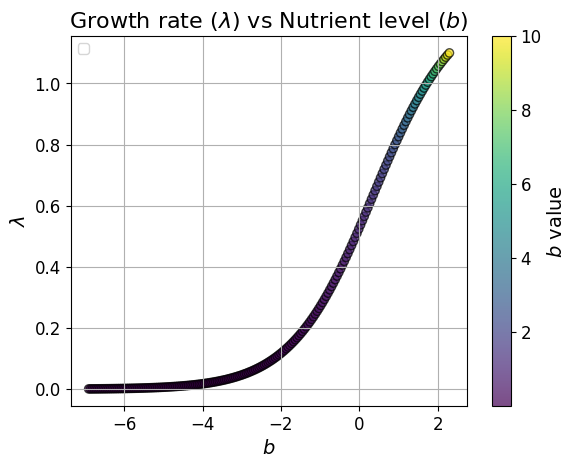

C:\Users\huang\AppData\Local\Temp\ipykernel_27184\1394382200.py:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


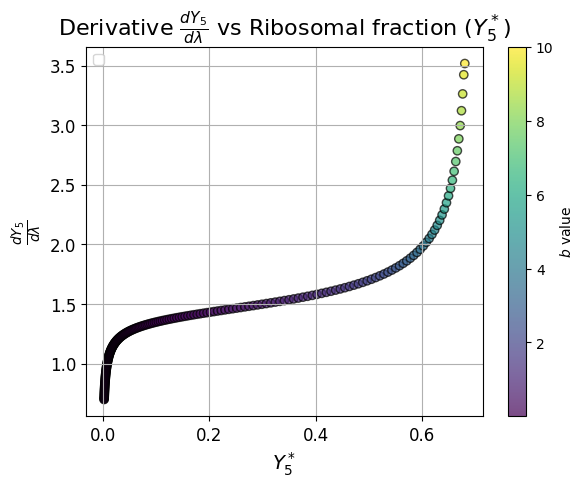

C:\Users\huang\AppData\Local\Temp\ipykernel_27184\1394382200.py:86: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


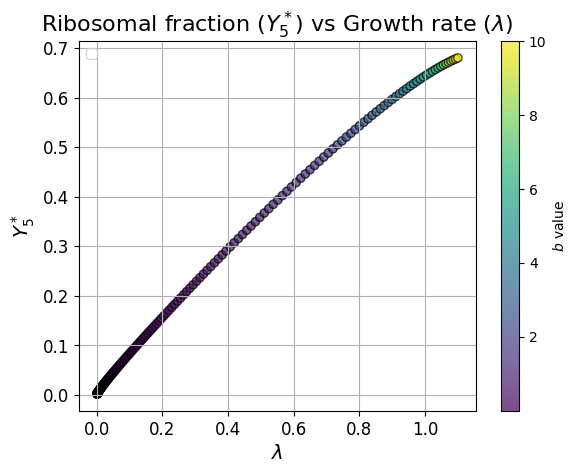

C:\Users\huang\AppData\Local\Temp\ipykernel_27184\1394382200.py:96: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


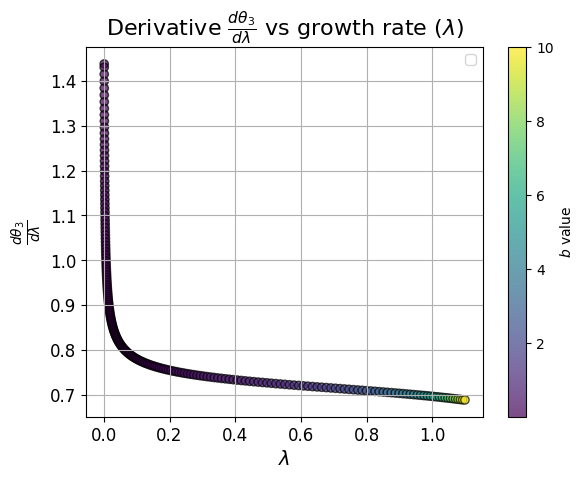

C:\Users\huang\AppData\Local\Temp\ipykernel_27184\1394382200.py:108: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


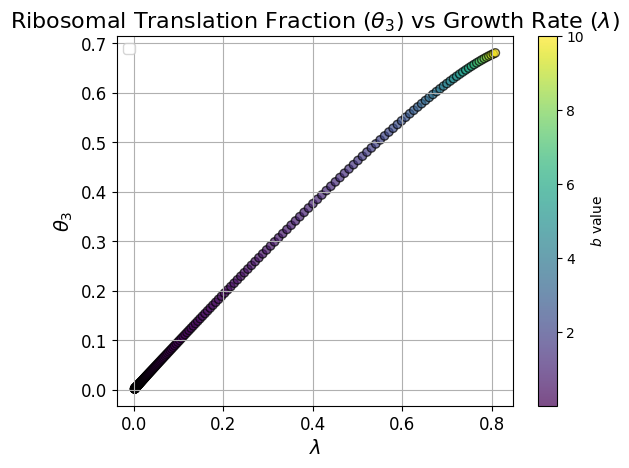

In [26]:
# Put in DataFrame
df = pd.DataFrame({
    "Nutrient level": b_arr,
    "Growth rate": lambda_arr,
    "Y1": Y1_arr,
    "Y2": Y2_arr,
    "Y3": Y3_arr,
    "Y4": Y4_arr,
    "Y5": Y5_arr,
    "Sum_Y": Y1_arr + Y2_arr + Y3_arr + Y4_arr + Y5_arr, 
    "Approx. Sum_Y": None
})
display(df)

tick_size = 12
label_size = 14
title_size = 16

# Growth rate to nutrient level (b)
if b_large:
    # A = np.sqrt(k1/a1) + np.sqrt(k2/a2)
    # not yet calculated
    pass
else:
    # A = np.sqrt(k1/a1) + np.sqrt(k2/a2)
    # B = (k1/a1) + (k2/a2)
    # F = (1/a1) + (1/a2)
    lambda_approx_arr = b_arr - 2*A*b_arr**(3/2) - ((5/2)*A**2 + (1/2)*B - F)*b_arr**2

# Calculate derivative d(lambda)/dY5
# Use chain rule with respect to b for stability: d(lambda)/dY5 = (d(lambda)/db) / (dY5/db)
# Smooth the data to reduce numerical noise before differentiation
window_length = 15
polyorder = 3
lambda_s = savgol_filter(lambda_arr, window_length, polyorder)
Y5_s = savgol_filter(Y5_arr, window_length, polyorder)
theta3_s = savgol_filter(theta3_arr, window_length, polyorder)

dlambda_db = np.gradient(lambda_s, b_arr)
dY5_db = np.gradient(Y5_s, b_arr)
dlambda_dY5_arr = dlambda_db / dY5_db

# d(theta3)/d(lambda) = (d(theta3)/db) / (d(lambda)/db)
dtheta3_db = np.gradient(theta3_s, b_arr)
dtheta3_dlambda_arr = dtheta3_db / dlambda_db

# Growth rate to nutrient level (b)
plt.figure()
scatter = plt.scatter(np.log(b_arr), lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
cbar = plt.colorbar(scatter)
cbar.set_label(r'$b$ value', fontsize=label_size)
cbar.ax.tick_params(labelsize=tick_size)
if b_large:
    pass 
else:
    pass
    # plt.plot(b_arr, lambda_approx_arr, '-', label=r'Approximate theory (small $b$)')
plt.xlabel(r'$b$', fontsize=label_size); plt.ylabel(r'$\lambda$', fontsize=label_size)
plt.title(r'Growth rate ($\lambda$) vs Nutrient level ($b$)', fontsize=title_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.legend()
plt.grid(True)
plt.show()


# Derivative d(Y5)/d(lambda) vs Y5
plt.figure()
scatter = plt.scatter(Y5_arr, dlambda_dY5_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$Y_5^*$', fontsize=label_size); plt.ylabel(r'$\frac{dY_5}{d\lambda}$', fontsize=label_size)
plt.title(r'Derivative $\frac{dY_5}{d\lambda}$ vs Ribosomal fraction ($Y_5^*$)', fontsize=title_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.legend()
plt.grid(True)
plt.show()

# ribosome protein fraction (Y5) vs growth rate 
plt.figure()
scatter = plt.scatter(lambda_arr, Y5_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
# plt.plot(lambda_Y5_fit[0], lambda_Y5_fit[1], '-', label=f'Linear fit: y = {lambda_Y5_fit[3]:.3f}x + {lambda_Y5_fit[4]:.3f}$R^2$ = {lambda_Y5_fit[2]:.4f}', color='red')
plt.xlabel(r'$\lambda$', fontsize=label_size); plt.ylabel(r'$Y_5^*$', fontsize=label_size)
plt.title(r'Ribosomal fraction ($Y_5^*$) vs Growth rate ($\lambda$)', fontsize=title_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.grid(True)
plt.legend()
plt.show()

# Derivative d(theta3)/d(lambda) vs lambda
plt.figure()
scatter = plt.scatter(lambda_arr, dtheta3_dlambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$\lambda$', fontsize=label_size); plt.ylabel(r'$\frac{d\theta_3}{d \lambda}$', fontsize=label_size)
plt.title(r'Derivative $\frac{d\theta_3}{d \lambda}$ vs growth rate ($\lambda$)', fontsize=title_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.legend()
plt.grid(True)
plt.show()

# Ribosome translation fraction (theta3) vs growth rate
plt.figure()
scatter = plt.scatter(theta3_arr, Y5_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$\lambda$', fontsize=label_size); plt.ylabel(r'$\theta_3$', fontsize=label_size)
plt.title(r'Ribosomal Translation Fraction ($\theta_3$) vs Growth Rate ($\lambda$)', fontsize=title_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.grid(True)
plt.legend()
plt.show()

Data saved to PP3_MM_output.csv (200 rows)
Excel output requires openpyxl package. Install with: pip install openpyxl


,Nutrient level,Growth rate,$Y_1,$Y_2,$Y_3,$Y_4,$Y_5,Sum_Y,$\theta_1$,$\theta_2$,$\theta_3$,$p = \frac{\theta_2}{\theta_1}$,$q = \frac{\theta_3}{\theta_1}$,$\sum \theta$,Approx. $\sum \theta$
0,0.001000,0.000995,0.000647,0.001460,0.995039,0.000687,0.002166,1.0,0.997140,0.000689,0.002171,0.000691,0.002177,1.0,1.0
1,0.001047,0.001042,0.000662,0.001494,0.994905,0.000704,0.002234,1.0,0.997056,0.000706,0.002239,0.000708,0.002245,1.0,1.0
2,0.001097,0.001091,0.000678,0.001529,0.994768,0.000722,0.002303,1.0,0.996968,0.000723,0.002309,0.000725,0.002316,1.0,1.0
3,0.001149,0.001143,0.000694,0.001565,0.994626,0.000740,0.002376,1.0,0.996878,0.000741,0.002381,0.000744,0.002388,1.0,1.0
4,0.001203,0.001197,0.000710,0.001602,0.994480,0.000758,0.002450,1.0,0.996784,0.000760,0.002456,0.000762,0.002464,1.0,1.0
5,0.001260,0.001253,0.000727,0.001639,0.994330,0.000777,0.002528,1.0,0.996688,0.000779,0.002534,0.000781,0.002542,1.0,1.0
6,0.001320,0.001312,0.000744,0.001677,0.994175,0.000796,0.002608,1.0,0.996588,0.000798,0.002614,0.000801,0.002623,1.0,1.0
7,0.001383,0.001374,0.000761,0.001716,0.994016,0.000816,0.002691,1.0,0.996484,0.000818,0.002698,0.000821,0.002707,1.0,1.0
8,0.001448,0.001439,0.000779,0.001756,0.993852,0.000836,0.002777,1.0,0.996378,0.000838,0.002784,0.000842,0.002794,1.0,1.0
9,0.001517,0.001507,0.000797,0.001797,0.993683,0.000857,0.002866,1.0,0.996267,0.000859,0.002873,0.000863,0.002884,1.0,1.0


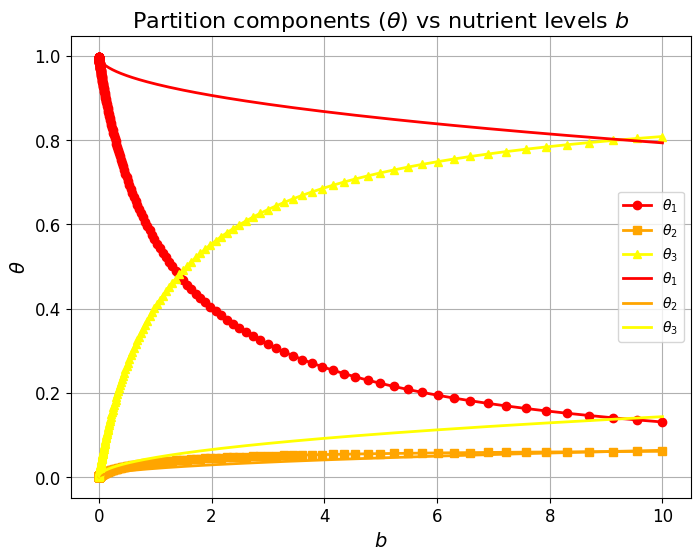

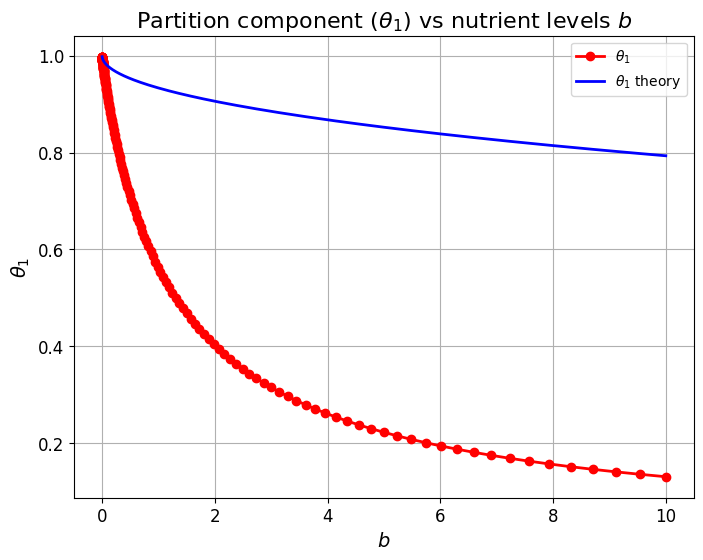

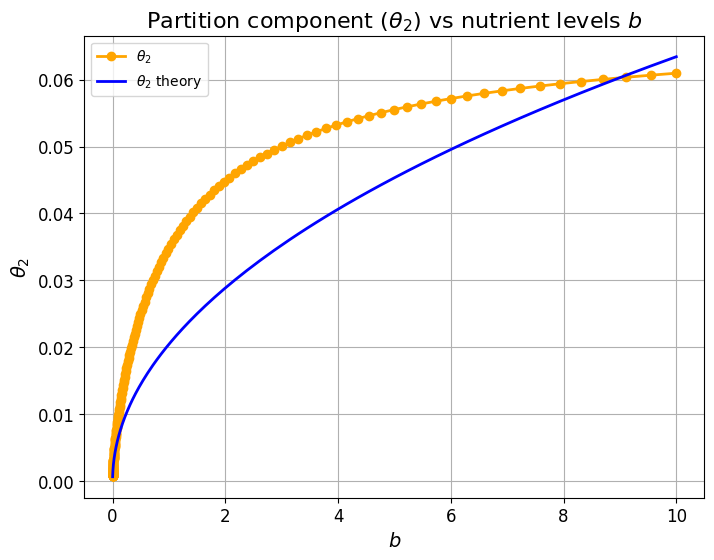

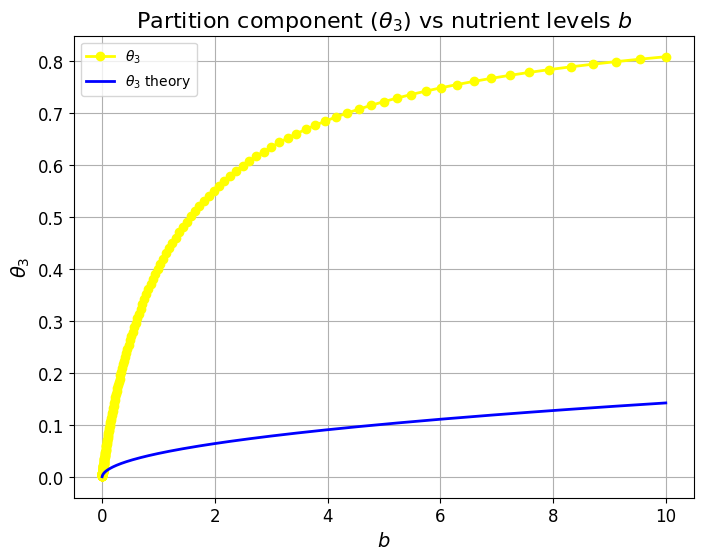

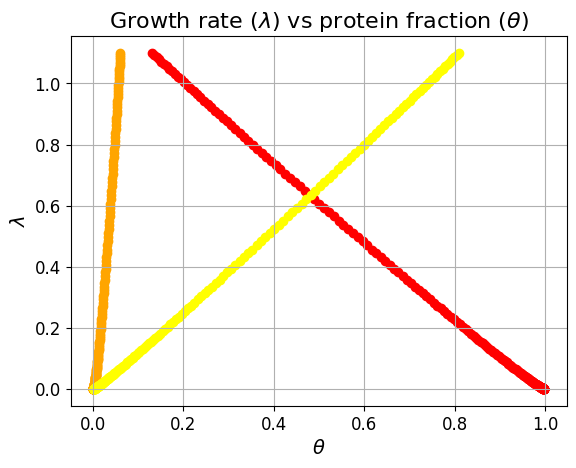

In [27]:
# Approximate Theory
# A = np.sqrt(k1/a1)+np.sqrt(k2/a2)
# B = k1/a1 + k2/a2
# C = a1/k1 + a2/k2
# D = np.sqrt((k1*k2) / (a1*a2))
# E = 1/a1 + 1/a2

if b_large:
    # not yet calculated
    theta1_approx_arr = np.full_like(b_arr, np.nan)
    theta2_approx_arr = np.full_like(b_arr, np.nan)
    theta3_approx_arr = np.full_like(b_arr, np.nan)
else:
    theta1_approx_arr = 1 - A*np.sqrt(b_arr) + (1/2)*A**3*b_arr**(3/2) - (3/8)*A**5*b_arr**(5/2)
    theta2_approx_arr = np.sqrt(k1/a1)*( np.sqrt(b_arr) - (1/2)*A**2*b_arr**(3/2) + (3/8)*A**4*b_arr**(5/2) )
    theta3_approx_arr = np.sqrt(k2/a2)*( np.sqrt(b_arr) - (1/2)*A**2*b_arr**(3/2) + (3/8)*A**4*b_arr**(5/2) )

# Put in DataFrame
df = pd.DataFrame({
    "Nutrient level": b_arr,
    "Growth rate": lambda_arr,
    r"$Y_1": Y1_arr,
    r"$Y_2": Y2_arr,
    r"$Y_3": Y3_arr,
    r"$Y_4": Y4_arr,
    r"$Y_5": Y5_arr,
    r"Sum_Y": Y1_arr + Y2_arr + Y3_arr + Y4_arr + Y5_arr, 
    r"$\theta_1$": theta1_arr,
    r"$\theta_2$": theta2_arr,
    r"$\theta_3$": theta3_arr,
    r"$p = \frac{\theta_2}{\theta_1}$": theta2_arr / theta1_arr,
    r"$q = \frac{\theta_3}{\theta_1}$": theta3_arr / theta1_arr,
    r"$\sum \theta$": theta1_arr + theta2_arr + theta3_arr,
    r"Approx. $\sum \theta$": theta1_approx_arr + theta2_approx_arr + theta3_approx_arr
})

# Save to CSV file
df.to_csv('PP3_MM_output.csv', index=False, float_format='%.6f')
print(f"Data saved to PP3_MM_output.csv ({len(df)} rows)")

# Also save to Excel for better formatting (optional)
try:
    df.to_excel('PP3_MM_output.xlsx', index=False, float_format='%.6f')
    print(f"Data also saved to PP3_MM_output.xlsx")
except ImportError:
    print("Excel output requires openpyxl package. Install with: pip install openpyxl")

# Display first few rows
display(df.head(10))


# Partition components to nutrient levels b
plt.figure(figsize=(8,6))
plt.plot(b_arr, theta1_arr, lw=2, label=r'$\theta_1$', marker='o', color='red')
plt.plot(b_arr, theta2_arr, lw=2, label=r'$\theta_2$', marker='s', color='orange')
plt.plot(b_arr, theta3_arr, lw=2, label=r'$\theta_3$', marker='^', color='yellow')
plt.plot(b_arr, theta1_approx_arr, lw=2, label=r'$\theta_1$', linestyle='-', color='red')
plt.plot(b_arr, theta2_approx_arr, lw=2, label=r'$\theta_2$', linestyle='-', color='orange')
plt.plot(b_arr, theta3_approx_arr, lw=2, label=r'$\theta_3$', linestyle='-', color='yellow')
plt.xlabel(r'$b$', fontsize=label_size)
plt.ylabel(r'$\theta$', fontsize=label_size)
plt.title(r'Partition components ($\theta$) vs nutrient levels $b$', fontsize=title_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.grid(True)
plt.legend()
plt.show()

# Partition component theta1 to nutrient levels b
plt.figure(figsize=(8,6))
plt.plot(b_arr, theta1_arr, lw=2, label=r'$\theta_1$', marker='o', color='red')
plt.plot(b_arr, theta1_approx_arr, lw=2, label=r'$\theta_1$ theory', color='blue')
plt.xlabel(r'$b$', fontsize=label_size); plt.ylabel(r'$\theta_1$', fontsize=label_size)
plt.title(r'Partition component ($\theta_1$) vs nutrient levels $b$', fontsize=title_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.grid(True)
plt.legend()
plt.show()

# Partition component theta2 to nutrient levels b
plt.figure(figsize=(8,6))
plt.plot(b_arr, theta2_arr, lw=2, label=r'$\theta_2$', marker='o', color='orange')
plt.plot(b_arr, theta2_approx_arr, lw=2, label=r'$\theta_2$ theory', color='blue')
plt.xlabel(r'$b$', fontsize=label_size); plt.ylabel(r'$\theta_2$', fontsize=label_size)
plt.title(r'Partition component ($\theta_2$) vs nutrient levels $b$', fontsize=title_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.grid(True)
# plt.ylim(0.0, 0.01)
plt.legend()
plt.show()

# Partition component theta3 to nutrient levels b
plt.figure(figsize=(8,6))
plt.plot(b_arr, theta3_arr, lw=2, label=r'$\theta_3$', marker='o', color='yellow')
plt.plot(b_arr, theta3_approx_arr, lw=2, label=r'$\theta_3$ theory', color='blue')
plt.xlabel(r'$b$', fontsize=label_size); plt.ylabel(r'$\theta_3$', fontsize=label_size)
plt.title(r'Partition component ($\theta_3$) vs nutrient levels $b$', fontsize=title_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.grid(True)
# plt.ylim(0.0, 0.01)
plt.legend()
plt.show()

# Growth rate to protein partition \theta
plt.figure()
plt.scatter(theta1_arr, lambda_arr, label=r'$\theta_1$', c='red')
plt.scatter(theta2_arr, lambda_arr, label=r'$\theta_2$', c='orange')
plt.scatter(theta3_arr, lambda_arr, label=r'$\theta_3$', c='yellow')
plt.xlabel(r'$\theta$', fontsize=label_size); plt.ylabel(r'$\lambda$', fontsize=label_size)
plt.title(r'Growth rate ($\lambda$) vs protein fraction ($\theta$)', fontsize=title_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.grid(True)
plt.show()

## Flux to Enzyme Activity
This section illustrates the important relations in metabolic control analysis (MCA). We discuss the relationship between flux, enzyme activity (equivalent to concentration when the enzymes are always active), and their sensitivity.

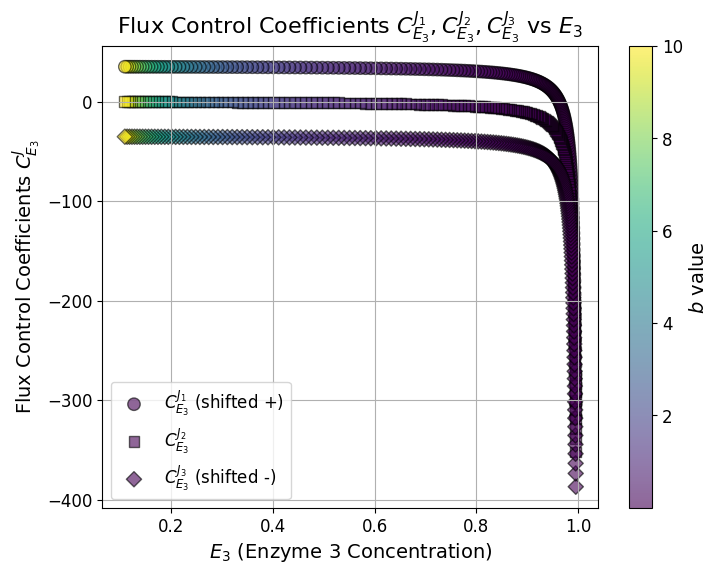

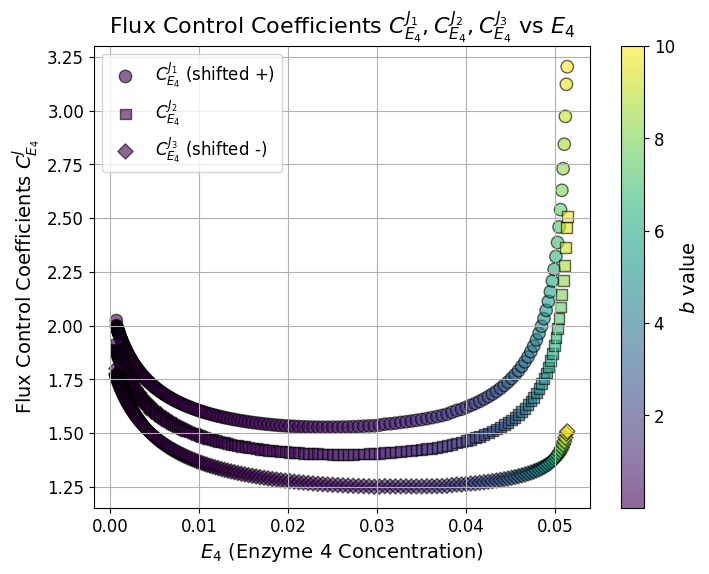

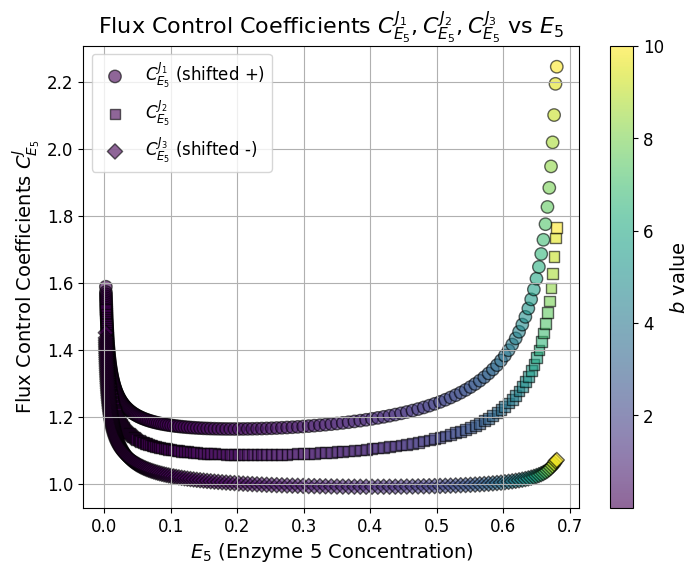

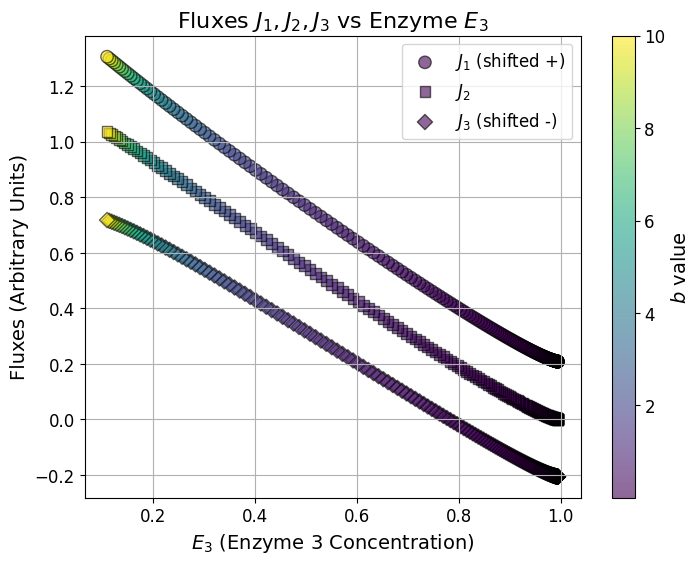

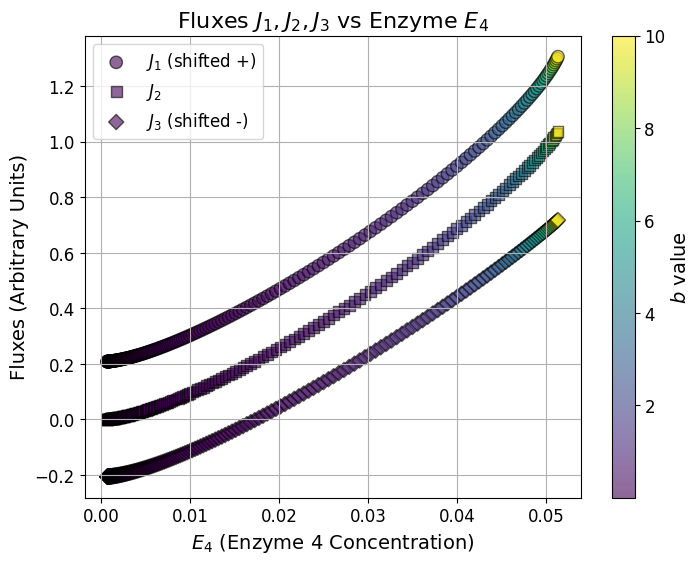

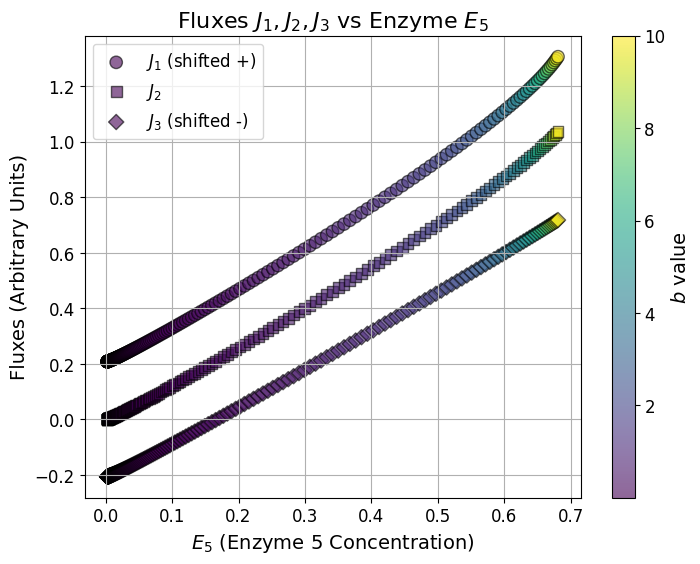

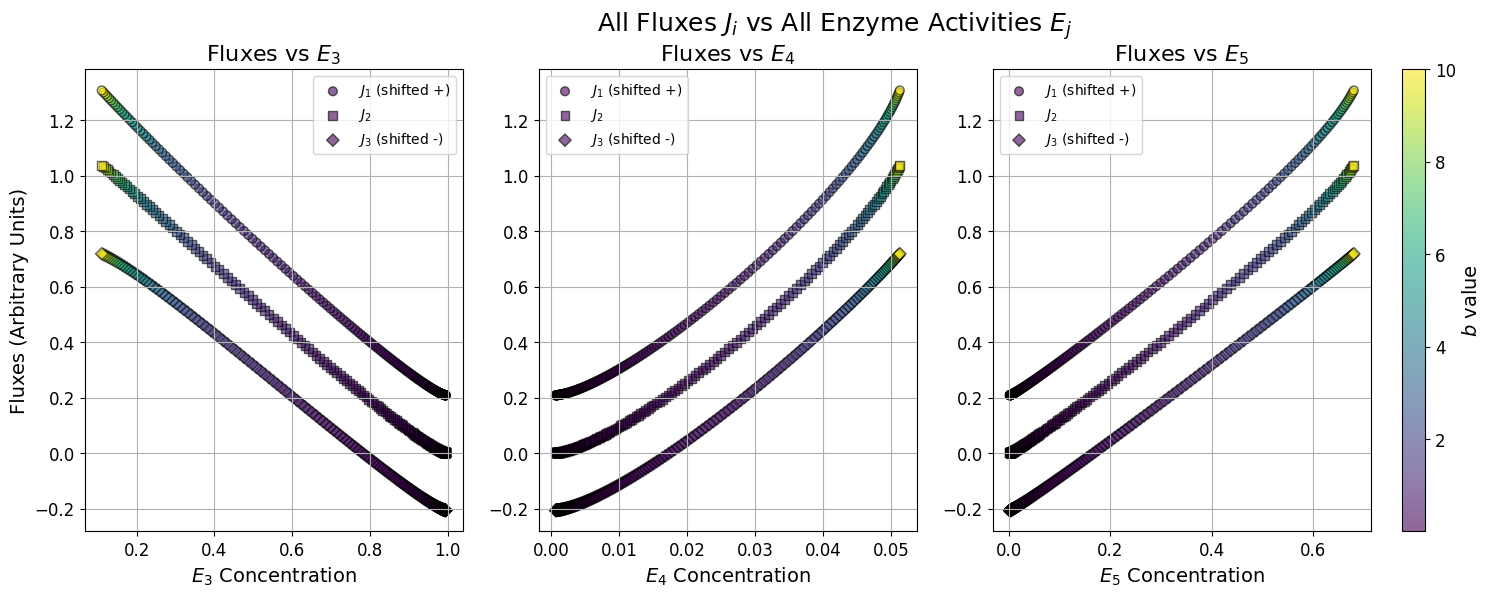

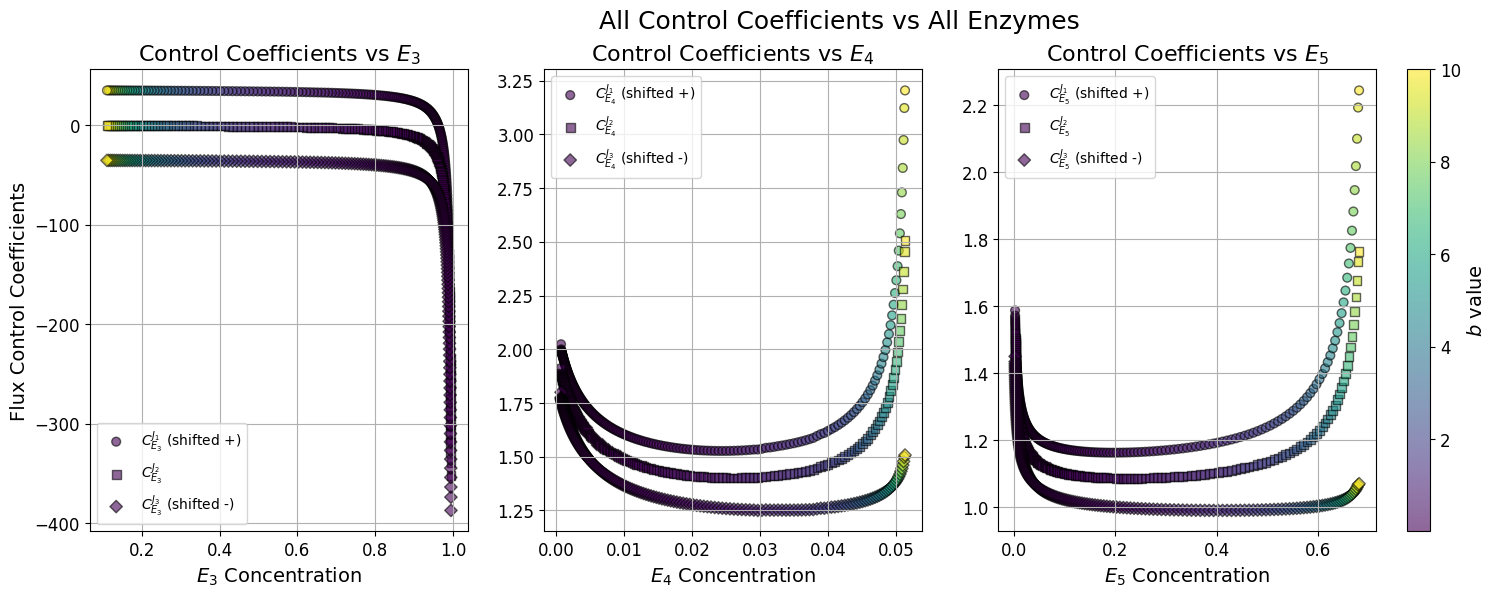

In [28]:
# Fluxes J1, J2, J3 (only the time-independent part
# since we will normalize by absolute biomass in the definition)
J1 = b_arr * Y3_arr
J2 = a1*Y1_arr*Y4_arr / (k1 + Y1_arr)
J3 = a2*Y2_arr*Y5_arr / (k2 + Y2_arr)

# Enzyme activity = enzyme concentration
E3, E4, E5 = Y3_arr, Y4_arr, Y5_arr

# Smooth the data to reduce numerical noise before differentiation
# This fixes the "unstable derivative" issue
window_length = 15
polyorder = 3
J1_s = savgol_filter(J1, window_length, polyorder)
J2_s = savgol_filter(J2, window_length, polyorder)
J3_s = savgol_filter(J3, window_length, polyorder)
E3_s = savgol_filter(E3, window_length, polyorder)
E4_s = savgol_filter(E4, window_length, polyorder)
E5_s = savgol_filter(E5, window_length, polyorder)

# Calculate derivatives for MCA using smoothed data
# d(J1)/d(E3) = (dJ1/db) / (dE3/db)
dJ1_db = np.gradient(J1_s, b_arr)
dJ2_db = np.gradient(J2_s, b_arr)
dJ3_db = np.gradient(J3_s, b_arr)

# --- E3 Analysis ---
dE3_db = np.gradient(E3_s, b_arr)

# Control coefficients for E3
# C_J_E3 = (E3/J) * (dJ/dE3)
dJ1_dE3 = dJ1_db / dE3_db
C_J1_E3 = (E3_s / J1_s) * dJ1_dE3

dJ2_dE3 = dJ2_db / dE3_db
C_J2_E3 = (E3_s / J2_s) * dJ2_dE3

dJ3_dE3 = dJ3_db / dE3_db
C_J3_E3 = (E3_s / J3_s) * dJ3_dE3

# Shift Control Coefficients for visualization
cc_scale_E3 = np.max(C_J2_E3) - np.min(C_J2_E3)
if cc_scale_E3 == 0: cc_scale_E3 = 1.0
cc_offset_E3 = 0.1 * cc_scale_E3

C_J1_E3_shifted = C_J1_E3 + cc_offset_E3
C_J3_E3_shifted = C_J3_E3 - cc_offset_E3

# Combined Plot: Control Coefficients of J1, J2, J3 vs E3
plt.figure(figsize=(8, 6))
plt.scatter(E3, C_J1_E3_shifted, c=b_arr, cmap='viridis', marker='o', s=80, label=r'$C_{E_3}^{J_1}$ (shifted +)', edgecolors='k', alpha=0.6)
plt.scatter(E3, C_J2_E3, c=b_arr, cmap='viridis', marker='s', s=60, label=r'$C_{E_3}^{J_2}$', edgecolors='k', alpha=0.6)
scatter = plt.scatter(E3, C_J3_E3_shifted, c=b_arr, cmap='viridis', marker='D', s=60, label=r'$C_{E_3}^{J_3}$ (shifted -)', edgecolors='k', alpha=0.6)

cbar = plt.colorbar(scatter)
cbar.set_label(r'$b$ value', fontsize=label_size)
cbar.ax.tick_params(labelsize=tick_size)

plt.xlabel(r'$E_3$ (Enzyme 3 Concentration)', fontsize=label_size)
plt.ylabel(r'Flux Control Coefficients $C_{E_3}^{J}$', fontsize=label_size)
plt.title(r'Flux Control Coefficients $C_{E_3}^{J_1}, C_{E_3}^{J_2}, C_{E_3}^{J_3}$ vs $E_3$', fontsize=title_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


# --- E4 Analysis ---
dE4_db = np.gradient(E4_s, b_arr)

dJ1_dE4 = dJ1_db / dE4_db
C_J1_E4 = (E4_s / J1_s) * dJ1_dE4

dJ2_dE4 = dJ2_db / dE4_db
C_J2_E4 = (E4_s / J2_s) * dJ2_dE4

dJ3_dE4 = dJ3_db / dE4_db
C_J3_E4 = (E4_s / J3_s) * dJ3_dE4

# Shift Control Coefficients for visualization
cc_scale_E4 = np.max(C_J2_E4) - np.min(C_J2_E4)
if cc_scale_E4 == 0: cc_scale_E4 = 1.0
cc_offset_E4 = 0.1 * cc_scale_E4

C_J1_E4_shifted = C_J1_E4 + cc_offset_E4
C_J3_E4_shifted = C_J3_E4 - cc_offset_E4

# Combined Plot: Control Coefficients of J1, J2, J3 vs E4
plt.figure(figsize=(8, 6))
plt.scatter(E4, C_J1_E4_shifted, c=b_arr, cmap='viridis', marker='o', s=80, label=r'$C_{E_4}^{J_1}$ (shifted +)', edgecolors='k', alpha=0.6)
plt.scatter(E4, C_J2_E4, c=b_arr, cmap='viridis', marker='s', s=60, label=r'$C_{E_4}^{J_2}$', edgecolors='k', alpha=0.6)
scatter = plt.scatter(E4, C_J3_E4_shifted, c=b_arr, cmap='viridis', marker='D', s=60, label=r'$C_{E_4}^{J_3}$ (shifted -)', edgecolors='k', alpha=0.6)

cbar = plt.colorbar(scatter)
cbar.set_label(r'$b$ value', fontsize=label_size)
cbar.ax.tick_params(labelsize=tick_size)

plt.xlabel(r'$E_4$ (Enzyme 4 Concentration)', fontsize=label_size)
plt.ylabel(r'Flux Control Coefficients $C_{E_4}^{J}$', fontsize=label_size)
plt.title(r'Flux Control Coefficients $C_{E_4}^{J_1}, C_{E_4}^{J_2}, C_{E_4}^{J_3}$ vs $E_4$', fontsize=title_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# --- E5 Analysis ---
dE5_db = np.gradient(E5_s, b_arr)

dJ1_dE5 = dJ1_db / dE5_db
C_J1_E5 = (E5_s / J1_s) * dJ1_dE5

dJ2_dE5 = dJ2_db / dE5_db
C_J2_E5 = (E5_s / J2_s) * dJ2_dE5

dJ3_dE5 = dJ3_db / dE5_db
C_J3_E5 = (E5_s / J3_s) * dJ3_dE5

# Shift Control Coefficients for visualization
cc_scale_E5 = np.max(C_J2_E5) - np.min(C_J2_E5)
if cc_scale_E5 == 0: cc_scale_E5 = 1.0
cc_offset_E5 = 0.1 * cc_scale_E5

C_J1_E5_shifted = C_J1_E5 + cc_offset_E5
C_J3_E5_shifted = C_J3_E5 - cc_offset_E5

# Combined Plot: Control Coefficients of J1, J2, J3 vs E5
plt.figure(figsize=(8, 6))
plt.scatter(E5, C_J1_E5_shifted, c=b_arr, cmap='viridis', marker='o', s=80, label=r'$C_{E_5}^{J_1}$ (shifted +)', edgecolors='k', alpha=0.6)
plt.scatter(E5, C_J2_E5, c=b_arr, cmap='viridis', marker='s', s=60, label=r'$C_{E_5}^{J_2}$', edgecolors='k', alpha=0.6)
scatter = plt.scatter(E5, C_J3_E5_shifted, c=b_arr, cmap='viridis', marker='D', s=60, label=r'$C_{E_5}^{J_3}$ (shifted -)', edgecolors='k', alpha=0.6)

cbar = plt.colorbar(scatter)
cbar.set_label(r'$b$ value', fontsize=label_size)
cbar.ax.tick_params(labelsize=tick_size)

plt.xlabel(r'$E_5$ (Enzyme 5 Concentration)', fontsize=label_size)
plt.ylabel(r'Flux Control Coefficients $C_{E_5}^{J}$', fontsize=label_size)
plt.title(r'Flux Control Coefficients $C_{E_5}^{J_1}, C_{E_5}^{J_2}, C_{E_5}^{J_3}$ vs $E_5$', fontsize=title_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


# Shift fluxes for visualization to distinguish curves
# Calculate a small offset based on the scale of the data
flux_scale = np.max(J2) - np.min(J2)
if flux_scale == 0: flux_scale = np.max(J2) if np.max(J2) != 0 else 1.0
offset = 0.2 * flux_scale # 20% shift

J1_shifted = J1 + offset
J3_shifted = J3 - offset

# Combined Plot: Fluxes J1, J2, J3 vs E3
plt.figure(figsize=(8, 6))
# Use different markers and slightly different sizes/alphas to make overlaps visible
plt.scatter(E3, J1_shifted, c=b_arr, cmap='viridis', marker='o', s=80, label=r'$J_1$ (shifted +)', edgecolors='k', alpha=0.6)
plt.scatter(E3, J2, c=b_arr, cmap='viridis', marker='s', s=60, label=r'$J_2$', edgecolors='k', alpha=0.6)
scatter = plt.scatter(E3, J3_shifted, c=b_arr, cmap='viridis', marker='D', s=60, label=r'$J_3$ (shifted -)', edgecolors='k', alpha=0.6)

cbar = plt.colorbar(scatter)
cbar.set_label(r'$b$ value', fontsize=label_size)
cbar.ax.tick_params(labelsize=tick_size)

plt.xlabel(r'$E_3$ (Enzyme 3 Concentration)', fontsize=label_size)
plt.ylabel(r'Fluxes (Arbitrary Units)', fontsize=label_size)
plt.title(r'Fluxes $J_1, J_2, J_3$ vs Enzyme $E_3$', fontsize=title_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Combined Plot: Fluxes J1, J2, J3 vs E4
plt.figure(figsize=(8, 6))
plt.scatter(E4, J1_shifted, c=b_arr, cmap='viridis', marker='o', s=80, label=r'$J_1$ (shifted +)', edgecolors='k', alpha=0.6)
plt.scatter(E4, J2, c=b_arr, cmap='viridis', marker='s', s=60, label=r'$J_2$', edgecolors='k', alpha=0.6)
scatter = plt.scatter(E4, J3_shifted, c=b_arr, cmap='viridis', marker='D', s=60, label=r'$J_3$ (shifted -)', edgecolors='k', alpha=0.6)

cbar = plt.colorbar(scatter)
cbar.set_label(r'$b$ value', fontsize=label_size)
cbar.ax.tick_params(labelsize=tick_size)

plt.xlabel(r'$E_4$ (Enzyme 4 Concentration)', fontsize=label_size)
plt.ylabel(r'Fluxes (Arbitrary Units)', fontsize=label_size)
plt.title(r'Fluxes $J_1, J_2, J_3$ vs Enzyme $E_4$', fontsize=title_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Combined Plot: Fluxes J1, J2, J3 vs E5
plt.figure(figsize=(8, 6))
plt.scatter(E5, J1_shifted, c=b_arr, cmap='viridis', marker='o', s=80, label=r'$J_1$ (shifted +)', edgecolors='k', alpha=0.6)
plt.scatter(E5, J2, c=b_arr, cmap='viridis', marker='s', s=60, label=r'$J_2$', edgecolors='k', alpha=0.6)
scatter = plt.scatter(E5, J3_shifted, c=b_arr, cmap='viridis', marker='D', s=60, label=r'$J_3$ (shifted -)', edgecolors='k', alpha=0.6)

cbar = plt.colorbar(scatter)
cbar.set_label(r'$b$ value', fontsize=label_size)
cbar.ax.tick_params(labelsize=tick_size)

plt.xlabel(r'$E_5$ (Enzyme 5 Concentration)', fontsize=label_size)
plt.ylabel(r'Fluxes (Arbitrary Units)', fontsize=label_size)
plt.title(r'Fluxes $J_1, J_2, J_3$ vs Enzyme $E_5$', fontsize=title_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Combined Subplots: All Fluxes vs All Enzymes
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False) # sharey=False because ranges might differ significantly

# Shift fluxes for visualization to distinguish curves
# Calculate a small offset based on the scale of the data
flux_scale = np.max(J2) - np.min(J2)
if flux_scale == 0: flux_scale = np.max(J2) if np.max(J2) != 0 else 1.0
offset = 0.2 * flux_scale # 20% shift

fluxes = [J1 + offset, J2, J3 - offset]
flux_labels = [r'$J_1$ (shifted +)', r'$J_2$', r'$J_3$ (shifted -)']
markers = ['o', 's', 'D']
enzymes = [E3, E4, E5]
enzyme_labels = [r'$E_3$', r'$E_4$', r'$E_5$']

for i, ax in enumerate(axes):
    enzyme = enzymes[i]
    enz_label = enzyme_labels[i]
    
    for J, fl_label, marker in zip(fluxes, flux_labels, markers):
        sc = ax.scatter(enzyme, J, c=b_arr, cmap='viridis', marker=marker, s=40, alpha=0.6, edgecolors='k', label=fl_label)
    
    ax.set_xlabel(f'{enz_label} Concentration', fontsize=label_size)
    if i == 0:
        ax.set_ylabel('Fluxes (Arbitrary Units)', fontsize=label_size)
    ax.set_title(f'Fluxes vs {enz_label}', fontsize=title_size)
    ax.grid(True)
    ax.legend(fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=tick_size)

# Add a single colorbar for the whole figure
cbar = fig.colorbar(sc, ax=axes.ravel().tolist(), pad=0.02)
cbar.set_label(r'$b$ value', fontsize=label_size)
cbar.ax.tick_params(labelsize=tick_size)

plt.suptitle(r'All Fluxes $J_i$ vs All Enzyme Activities $E_j$', fontsize=title_size+2)
plt.show()

# Combined Subplots: All Control Coefficients vs All Enzymes
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)

enzymes = [E3, E4, E5]
enzyme_labels = [r'$E_3$', r'$E_4$', r'$E_5$']

# Group CCs
ccs_group = [
    [C_J1_E3_shifted, C_J2_E3, C_J3_E3_shifted],
    [C_J1_E4_shifted, C_J2_E4, C_J3_E4_shifted],
    [C_J1_E5_shifted, C_J2_E5, C_J3_E5_shifted]
]

markers = ['o', 's', 'D']

for i, ax in enumerate(axes):
    enzyme = enzymes[i]
    enz_idx = i + 3
    ccs = ccs_group[i]
    
    labels = [
        r'$C_{E_' + str(enz_idx) + r'}^{J_1}$ (shifted +)',
        r'$C_{E_' + str(enz_idx) + r'}^{J_2}$',
        r'$C_{E_' + str(enz_idx) + r'}^{J_3}$ (shifted -)'
    ]
    
    for cc, marker, lbl in zip(ccs, markers, labels):
        sc = ax.scatter(enzyme, cc, c=b_arr, cmap='viridis', marker=marker, s=40, alpha=0.6, edgecolors='k', label=lbl)
        
    ax.set_xlabel(f'{enzyme_labels[i]} Concentration', fontsize=label_size)
    if i == 0:
        ax.set_ylabel('Flux Control Coefficients', fontsize=label_size)
    ax.set_title(f'Control Coefficients vs {enzyme_labels[i]}', fontsize=title_size)
    ax.grid(True)
    ax.legend(fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=tick_size)

# Add a single colorbar for the whole figure
cbar = fig.colorbar(sc, ax=axes.ravel().tolist(), pad=0.02)
cbar.set_label(r'$b$ value', fontsize=label_size)
cbar.ax.tick_params(labelsize=tick_size)

plt.suptitle('All Control Coefficients vs All Enzymes', fontsize=title_size+2)
plt.show()

## Growth Rate Landscape
The general growth rate landscape is plotted, and the optimal growth rate contour is drawn.

C:\Users\huang\AppData\Local\Temp\ipykernel_27184\3969671191.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  r_denom = ((k1 + Y1) / (a1 * Y4)) + ((k2 + Y2) / (a2 * Y5))


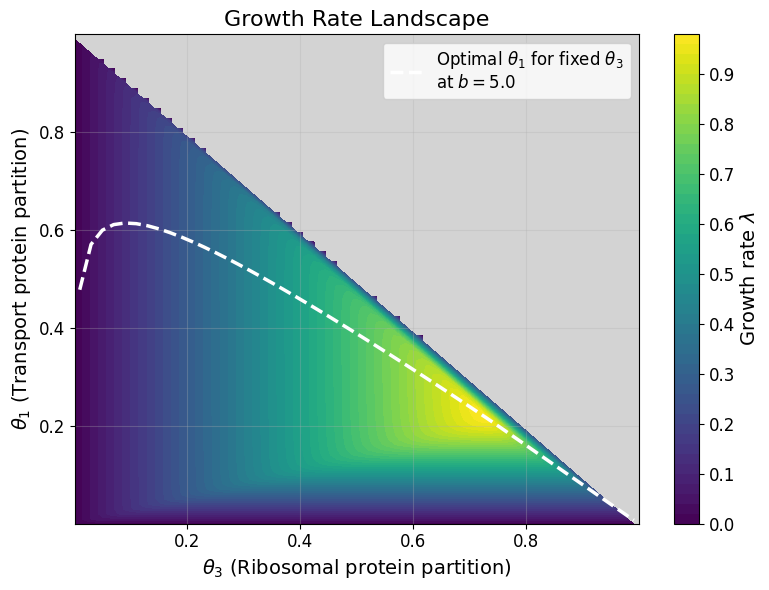

In [7]:
from scipy.optimize import minimize_scalar

b_contour = 5.0

N_grid = 100
t3_vals = np.linspace(0.001, 0.999, N_grid)
t1_vals = np.linspace(0.001, 0.999, N_grid)
T3, T1 = np.meshgrid(t3_vals, t1_vals)
Lambda_grid = np.full_like(T3, np.nan)

for i in range(N_grid):
    for j in range(N_grid):
        t3 = T3[i, j]
        t1 = T1[i, j]
        t2 = 1.0 - t1 - t3
        if t2 > 0:
            res = BioSystemMM3([t1, t2, t3], b_contour)
            Lambda_grid[i, j] = res[9]

line_t3 = np.linspace(0.01, 0.99, 50)
line_t1 = []

for t3_fixed in line_t3:
    # Maximize lambda(t1) subject to 0 <= t1 <= 1 - t3_fixed
    # theta2 = 1 - t1 - t3_fixed
    
    def objective(t1):
        t2 = 1.0 - t1 - t3_fixed
        if t2 <= 0: return 1e10 # Penalty
        res = BioSystemMM3([t1, t2, t3_fixed], b_contour)
        return -res[9] # Negative for minimization

    upper_bound = 1.0 - t3_fixed - 1e-7 # Small epsilon to avoid t2=0
    if upper_bound < 0: upper_bound = 0
    
    res = minimize_scalar(objective, bounds=(0, upper_bound), method='bounded')
    
    if res.success:
        line_t1.append(res.x)
    else:
        line_t1.append(np.nan)

# 4. Plot
plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.set_facecolor('lightgrey') # Color the invalid region (where theta1 + theta3 > 1) grey

# Contour
cp = plt.contourf(T3, T1, Lambda_grid, levels=50, cmap='viridis')
cbar = plt.colorbar(cp)
cbar.set_label(r'Growth rate $\lambda$', fontsize=label_size)
cbar.ax.tick_params(labelsize=tick_size)

# Optimal Line
plt.plot(line_t3, line_t1, 'w--', linewidth=2.5, label=r'Optimal $\theta_1$ for fixed $\theta_3$' + '\n' + r'at $b={:.1f}$'.format(b_contour))

# Labels
plt.xlabel(r'$\theta_3$ (Ribosomal protein partition)', fontsize=label_size)
plt.ylabel(r'$\theta_1$ (Transport protein partition)', fontsize=label_size)
plt.title(f'Growth Rate Landscape', fontsize=title_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Calculating landscape (this may take a moment)...
Calculating optimal trajectory...


C:\Users\huang\AppData\Local\Temp\ipykernel_27184\3969671191.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  r_denom = ((k1 + Y1) / (a1 * Y4)) + ((k2 + Y2) / (a2 * Y5))
C:\Users\huang\AppData\Local\Temp\ipykernel_27184\3969671191.py:30: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result = minimize(
C:\Users\huang\AppData\Local\Temp\ipykernel_27184\3969671191.py:30: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result = minimize(


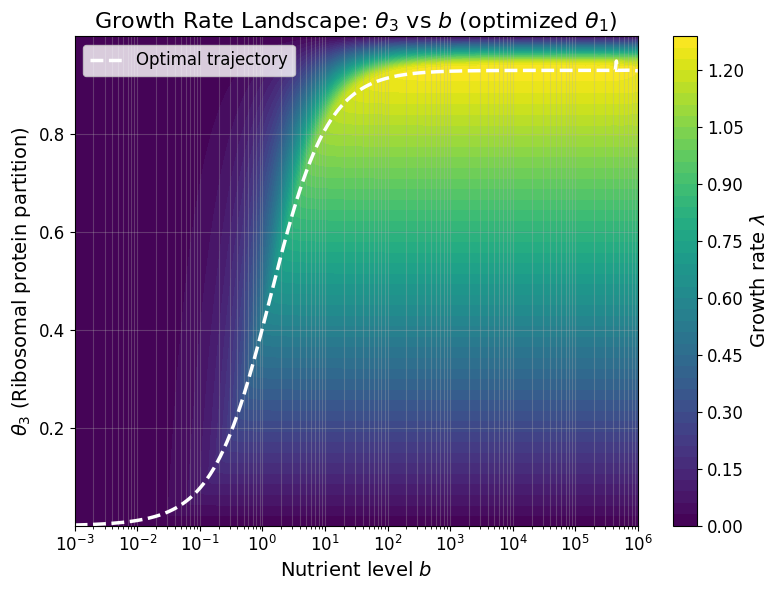

In [8]:
# Growth rate landscape: b vs theta3 (optimized over theta1)
# "Similar plot" with b on x-axis (1e-2 to 1e2) and theta3 on y-axis, growth rate on z-axis (color)

b_min_landscape = 1e-3
b_max_landscape = 1e6
N_grid_b = 500
N_grid_t3 = 500

b_vals_landscape = np.logspace(np.log10(b_min_landscape), np.log10(b_max_landscape), N_grid_b)
t3_vals_landscape = np.linspace(0.001, 0.999, N_grid_t3)

B_grid, T3_grid = np.meshgrid(b_vals_landscape, t3_vals_landscape)
Lambda_grid_opt = np.full_like(B_grid, np.nan)

print("Calculating landscape (this may take a moment)...")

for i in range(N_grid_t3):
    for j in range(N_grid_b):
        t3_val = T3_grid[i, j]
        b_val = B_grid[i, j]
        
        # Maximize lambda over theta1, given fixed theta3 and b
        # theta2 = 1 - theta1 - theta3
        # We need to find the optimal theta1 that maximizes growth rate
        
        def objective_t1(t1):
            t2 = 1.0 - t1 - t3_val
            if t2 <= 0: return 1e10 # Penalty
            res = BioSystemMM3([t1, t2, t3_val], b_val)
            return -res[9] # Negative lambda for minimization

        upper_bound = 1.0 - t3_val - 1e-7
        if upper_bound < 0: upper_bound = 0
        
        # Use bounded optimization to find best theta1
        res = minimize_scalar(objective_t1, bounds=(0, upper_bound), method='bounded')
        
        if res.success:
            Lambda_grid_opt[i, j] = -res.fun
        else:
            Lambda_grid_opt[i, j] = np.nan

# Calculate optimal trajectory for the specific b range of the landscape
print("Calculating optimal trajectory...")
t3_opt_vals_landscape = []
for b in b_vals_landscape:
    res = optimize_for_b_softmax(b)
    t3_opt_vals_landscape.append(res[3]) # theta3 is at index 3
t3_opt_vals_landscape = np.array(t3_opt_vals_landscape)

# Plot
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Contour plot (Z axis is color)
cp = plt.contourf(B_grid, T3_grid, Lambda_grid_opt, levels=50, cmap='viridis')
cbar = plt.colorbar(cp)
cbar.set_label(r'Growth rate $\lambda$', fontsize=label_size)
cbar.ax.tick_params(labelsize=tick_size)

# Optimal trajectory
plt.plot(b_vals_landscape, t3_opt_vals_landscape, 'w--', linewidth=2.5, label='Optimal trajectory')
plt.legend(loc='upper left', fontsize=12)

plt.xscale('log')
plt.xlabel(r'Nutrient level $b$', fontsize=label_size)
plt.ylabel(r'$\theta_3$ (Ribosomal protein partition)', fontsize=label_size)
plt.title(r'Growth Rate Landscape: $\theta_3$ vs $b$ (optimized $\theta_1$)', fontsize=title_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()

### Small and Large Molecules
The small molecules include metabolites and precursors. Large molecules include different types of proteins.

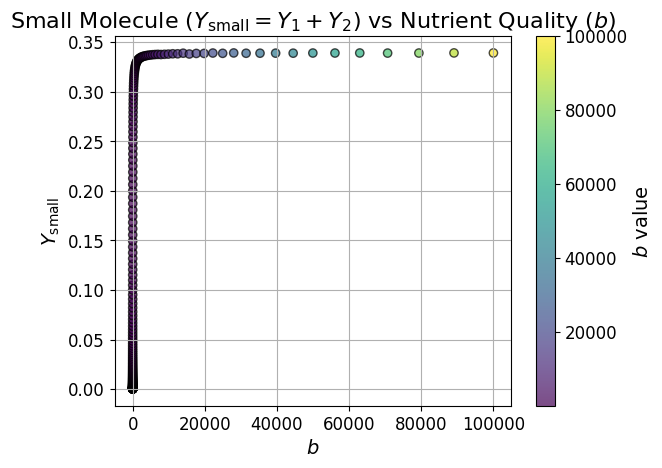

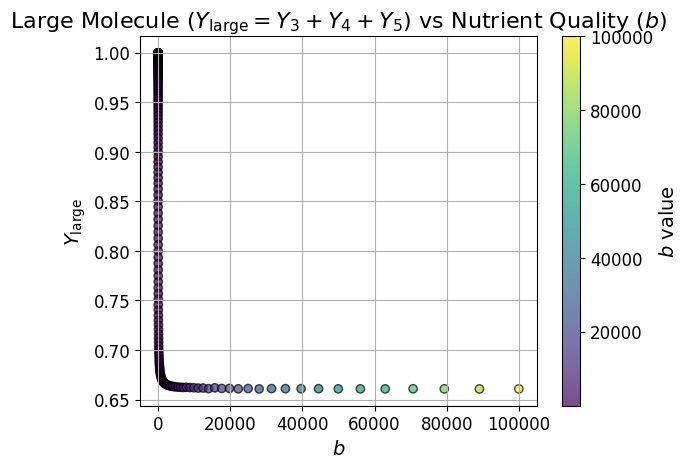

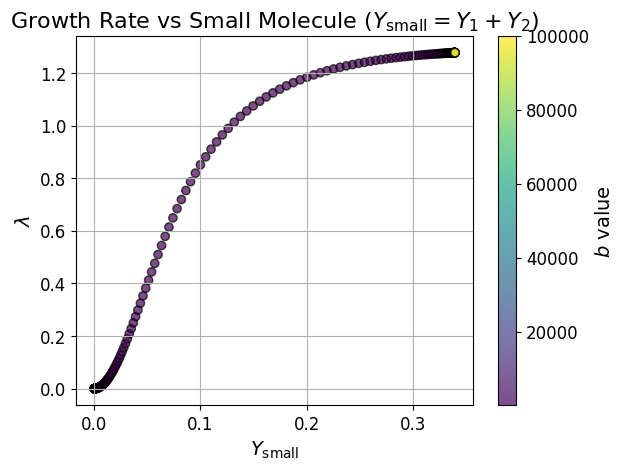

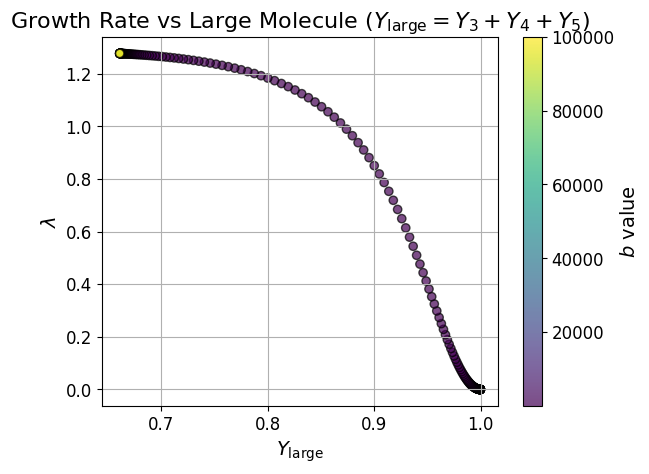

In [196]:
# Discuss different molecdule sizes
small_mol_arr = Y1_arr + Y2_arr
large_mol_arr = Y3_arr + Y4_arr + Y5_arr

# Small molecule (metabolites and a.a.'s) fraction (Y1 + Y2) to b
plt.figure()
scatter = plt.scatter(b_arr, small_mol_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
cbar = plt.colorbar(scatter)
cbar.set_label(r'$b$ value', fontsize=label_size)
cbar.ax.tick_params(labelsize=tick_size)
plt.xlabel(r'$b$', fontsize=label_size)
plt.ylabel(r'$Y_\text{small}$', fontsize=label_size)
plt.title(r'Small Molecule ($Y_\text{small} = Y_1 + Y_2$) vs Nutrient Quality ($b$)', fontsize=title_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.grid(True)
plt.show()

# Large molecule (proteins) fraction (Y3 + Y4 + Y5) to b
plt.figure()
scatter = plt.scatter(b_arr, large_mol_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
cbar = plt.colorbar(scatter)
cbar.set_label(r'$b$ value', fontsize=label_size)
cbar.ax.tick_params(labelsize=tick_size)
plt.xlabel(r'$b$', fontsize=label_size)
plt.ylabel(r'$Y_\text{large}$', fontsize=label_size)
plt.title(r'Large Molecule ($Y_\text{large} = Y_3 + Y_4 + Y_5$) vs Nutrient Quality ($b$)', fontsize=title_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.grid(True)
plt.show()

# Large molecule (proteins) fraction (Y3 + Y4 + Y5) to b
plt.figure()
scatter = plt.scatter(small_mol_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
cbar = plt.colorbar(scatter)
cbar.set_label(r'$b$ value', fontsize=label_size)
cbar.ax.tick_params(labelsize=tick_size)
plt.xlabel(r'$Y_\text{small}$', fontsize=label_size)
plt.ylabel(r'$\lambda$', fontsize=label_size)
plt.title(r'Growth Rate vs Small Molecule ($Y_\text{small} = Y_1 + Y_2$)', fontsize=title_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.grid(True)
plt.show()

# Large molecule (proteins) fraction (Y3 + Y4 + Y5) to b
plt.figure()
scatter = plt.scatter(large_mol_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
cbar = plt.colorbar(scatter)
cbar.set_label(r'$b$ value', fontsize=label_size)
cbar.ax.tick_params(labelsize=tick_size)
plt.xlabel(r'$Y_\text{large}$', fontsize=label_size)
plt.ylabel(r'$\lambda$', fontsize=label_size)
plt.title(r'Growth Rate vs Large Molecule ($Y_\text{large} = Y_3 + Y_4 + Y_5$)', fontsize=title_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.grid(True)
plt.show()


## Artificial Cell
Here we discuss what happens if the proteome partition is not optimal, but artificially setting the partition strength to fixed values. 

Note: theta values sum to 3.0000. Normalized to (0.3333, 0.3333, 0.3333)
At b = 3.11e+06 (midpoint):
  Optimal θ = (0.0000, 0.0807, 0.9193)


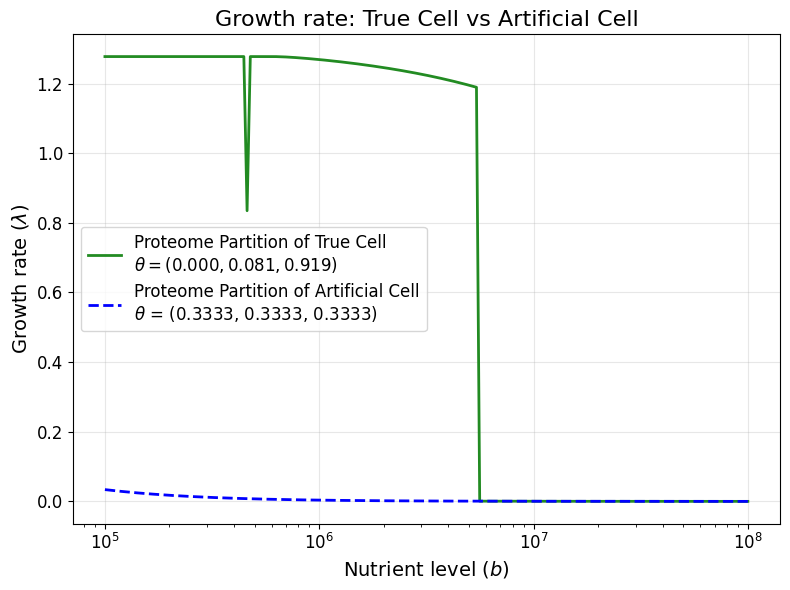

Note: theta values sum to 1002.0000. Normalized to (0.0010, 0.0010, 0.9980)
At b = 3.11e+06 (midpoint):
  Optimal θ = (0.0000, 0.0807, 0.9193)


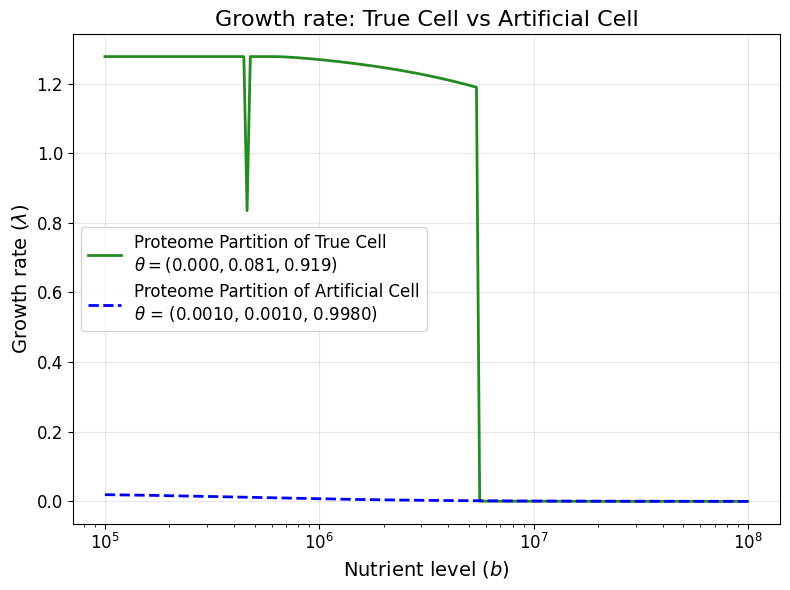

Note: theta values sum to 1002.0000. Normalized to (0.0010, 0.9980, 0.0010)
At b = 3.11e+06 (midpoint):
  Optimal θ = (0.0000, 0.0807, 0.9193)


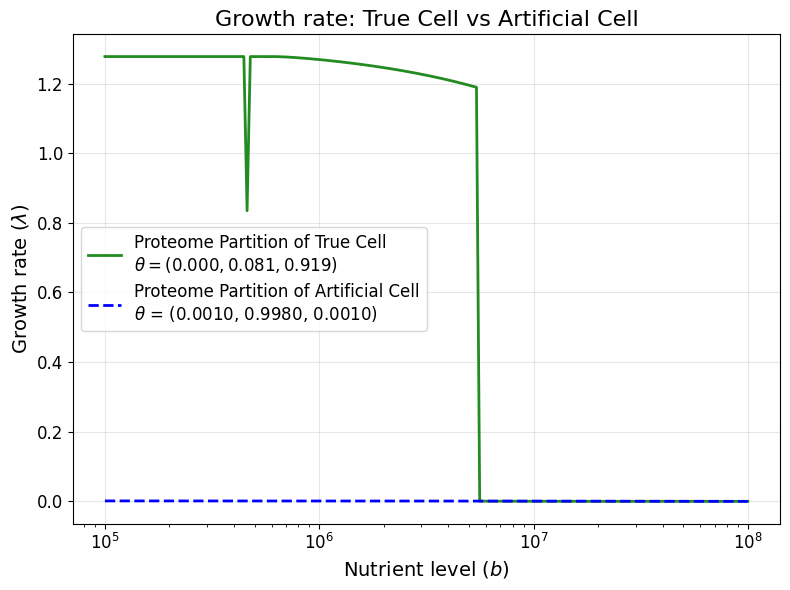

Note: theta values sum to 1002.0000. Normalized to (0.9980, 0.0010, 0.0010)
At b = 3.11e+06 (midpoint):
  Optimal θ = (0.0000, 0.0807, 0.9193)


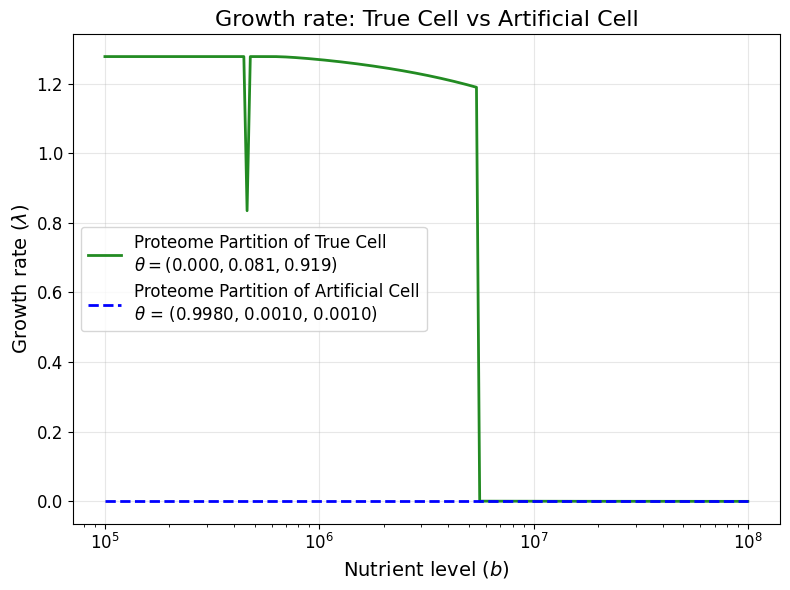

Note: theta values sum to 2001.0000. Normalized to (0.4998, 0.4998, 0.0005)
At b = 3.11e+06 (midpoint):
  Optimal θ = (0.0000, 0.0807, 0.9193)


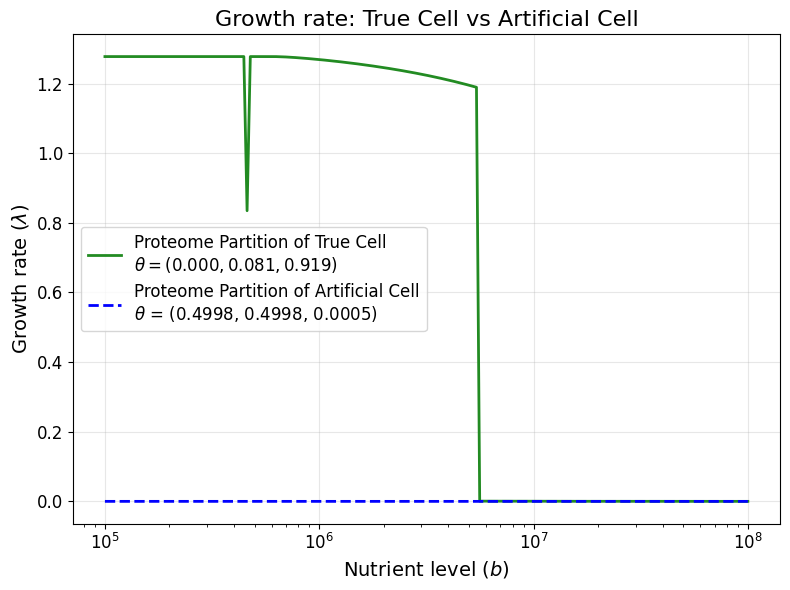

Note: theta values sum to 2001.0000. Normalized to (0.4998, 0.0005, 0.4998)
At b = 3.11e+06 (midpoint):
  Optimal θ = (0.0000, 0.0807, 0.9193)


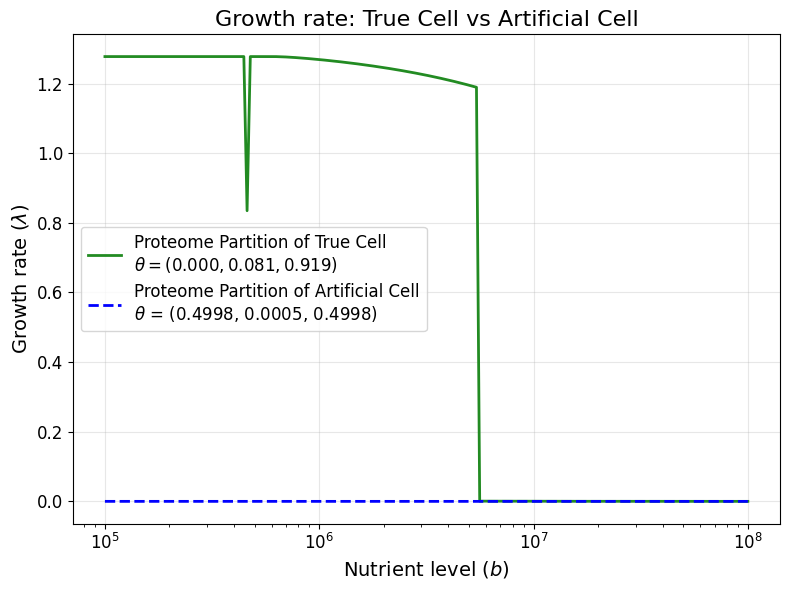

Note: theta values sum to 2001.0000. Normalized to (0.0005, 0.4998, 0.4998)
At b = 3.11e+06 (midpoint):
  Optimal θ = (0.0000, 0.0807, 0.9193)


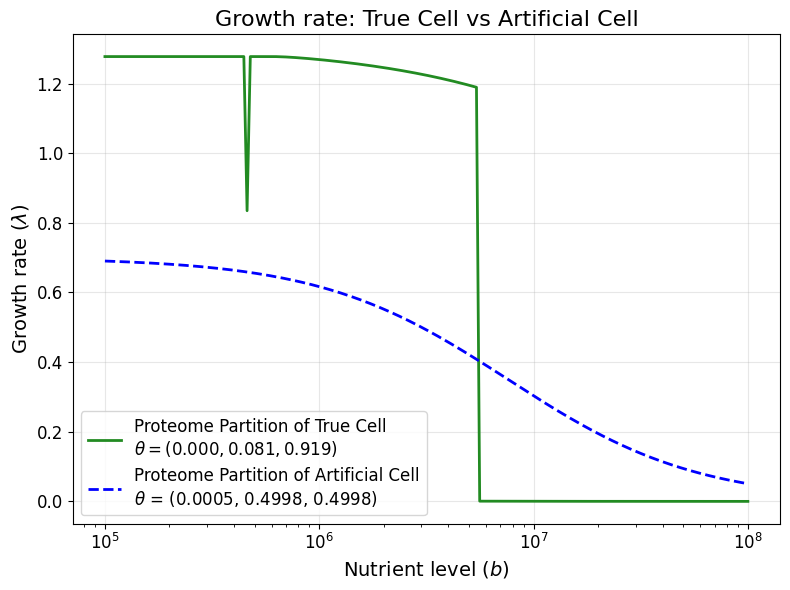

In [45]:
def ArtificialCell(theta_fixed, plot_growth=True, plot_trajectory=False):
    theta1_fixed, theta2_fixed, theta3_fixed = theta_fixed
    
    theta_sum = theta1_fixed + theta2_fixed + theta3_fixed # Validate input
    if not np.isclose(theta_sum, 1.0):
        theta1_fixed /= theta_sum
        theta2_fixed /= theta_sum
        theta3_fixed /= theta_sum
        print(f"Note: theta values sum to {theta_sum:.4f}. Normalized to ({theta1_fixed:.4f}, {theta2_fixed:.4f}, {theta3_fixed:.4f})")
    
    # Calculate Y and lambda for each b with fixed theta (use same b values as optimization)
    results_fixed = []
    for b in b_vals:
        result = BioSystemMM3([theta1_fixed, theta2_fixed, theta3_fixed], b)
        results_fixed.append(result)
    
    results_fixed = np.array(results_fixed)
    
    (b_fixed, _, _, _, Y1_fixed, Y2_fixed, Y3_fixed, Y4_fixed, Y5_fixed, 
     lambda_fixed, _) = results_fixed.T
    
    # Find midpoint b value and corresponding optimal theta
    b_mid = np.sqrt(b_min * b_max)  # Geometric mean for log scale
    mid_idx = np.argmin(np.abs(b_arr - b_mid))
    b_mid_actual = b_arr[mid_idx]
    theta1_opt_mid = theta1_arr[mid_idx]
    theta2_opt_mid = theta2_arr[mid_idx]
    theta3_opt_mid = theta3_arr[mid_idx]
    
    print(f"At b = {b_mid_actual:.2e} (midpoint):")
    print(f"  Optimal θ = ({theta1_opt_mid:.4f}, {theta2_opt_mid:.4f}, {theta3_opt_mid:.4f})")
    
    # Plot growth rate vs b for fixed theta
    if plot_growth:
        plt.figure(figsize=(8, 6))
        plt.plot(b_arr, lambda_arr, lw=2, color='ForestGreen', linestyle='-', 
                 label=f'Proteome Partition of True Cell\n$\\theta = ({theta1_opt_mid:.3f}, {theta2_opt_mid:.3f}, {theta3_opt_mid:.3f})$')
        plt.plot(b_fixed, lambda_fixed, lw=2, color='blue', linestyle='--',
                 label=f'Proteome Partition of Artificial Cell\n$\\theta$ = ({theta1_fixed:.4f}, {theta2_fixed:.4f}, {theta3_fixed:.4f})')
        plt.xlabel(r'Nutrient level ($b$)', fontsize=label_size)
        plt.ylabel(r'Growth rate ($\lambda$)', fontsize=label_size)
        plt.title(f'Growth rate: True Cell vs Artificial Cell', fontsize=title_size)
        plt.tick_params(axis='both', which='major', labelsize=tick_size)
        plt.xscale('log')
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=12)
        plt.tight_layout()
        plt.show()
    
    # Plot Y values vs b
    if plot_trajectory:
        plt.figure(figsize=(8, 6))
        plt.plot(b_fixed, Y1_fixed, lw=2, label='$Y_1$ (fixed)', color='red', linestyle='-')
        plt.plot(b_fixed, Y2_fixed, lw=2, label='$Y_2$ (fixed)', color='orange', linestyle='-')
        plt.plot(b_fixed, Y3_fixed, lw=2, label='$Y_3$ (fixed)', color='yellow', linestyle='-')
        plt.plot(b_fixed, Y4_fixed, lw=2, label='$Y_4$ (fixed)', color='green', linestyle='-')
        plt.plot(b_fixed, Y5_fixed, lw=2, label='$Y_5$ (fixed)', color='blue', linestyle='-')
        
        # Add optimized Y values
        plt.plot(b_arr, Y1_arr, lw=2, label='$Y_1$ (optimal)', color='red', linestyle='--', alpha=0.7)
        plt.plot(b_arr, Y2_arr, lw=2, label='$Y_2$ (optimal)', color='orange', linestyle='--', alpha=0.7)
        plt.plot(b_arr, Y3_arr, lw=2, label='$Y_3$ (optimal)', color='yellow', linestyle='--', alpha=0.7)
        plt.plot(b_arr, Y4_arr, lw=2, label='$Y_4$ (optimal)', color='green', linestyle='--', alpha=0.7)
        plt.plot(b_arr, Y5_arr, lw=2, label='$Y_5$ (optimal)', color='blue', linestyle='--', alpha=0.7)
        
        plt.xlabel(r'Nutrient level ($b$)', fontsize=label_size)
        plt.ylabel(r'Protein fractions ($Y$)', fontsize=label_size)
        plt.title(f'Protein Fractions: Fixed vs Optimized Partition', fontsize=title_size)
        plt.tick_params(axis='both', which='major', labelsize=tick_size)
        plt.xscale('log')
        plt.grid(True, alpha=0.3)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

# Different limits
ArtificialCell([1,1,1])
ArtificialCell([1, 1, 1000])
ArtificialCell([1, 1000, 1])
ArtificialCell([1000, 1, 1])
ArtificialCell([1000, 1000, 1])
ArtificialCell([1000, 1, 1000])
ArtificialCell([1, 1000, 1000])

C:\Users\huang\AppData\Local\Temp\ipykernel_30032\2833846779.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  r_denom = ((k1 + Y1) / (a1 * Y4)) + ((k2 + Y2) / (a2 * Y5))


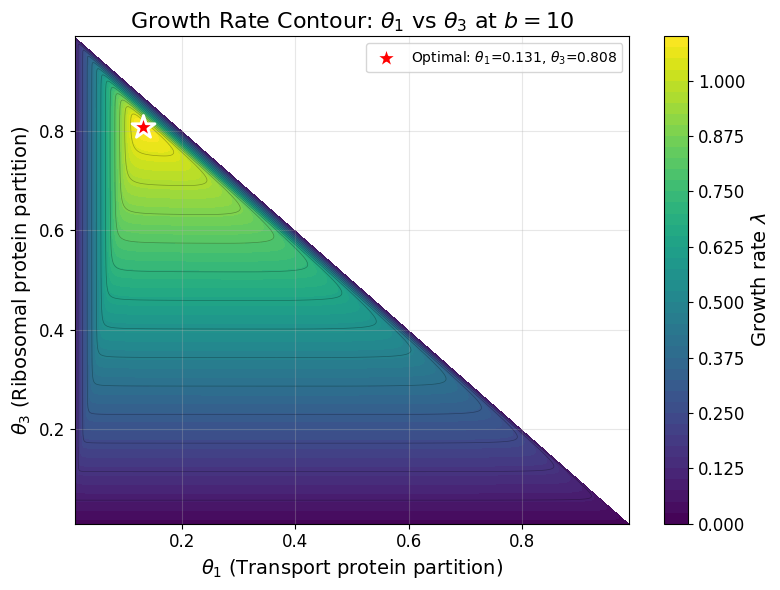

Optimal theta at b=10: theta1=0.1306, theta2=0.0610, theta3=0.8084
Maximum growth rate: lambda=1.0994


In [46]:
# Contour plot: Growth rate as function of theta2 and theta3 at fixed b
b_contour = 10

# Create grid for theta2 and theta3
theta1_vals = np.linspace(0.01, 0.99, 500)
theta3_vals = np.linspace(0.01, 0.99, 500)
Theta1, Theta3 = np.meshgrid(theta1_vals, theta3_vals)

# Calculate lambda for each (theta2, theta3) pair
Lambda_contour = np.empty_like(Theta1)

for i in range(Theta1.shape[0]):
    for j in range(Theta1.shape[1]):
        theta1 = Theta1[i, j]
        theta3 = Theta3[i, j]
        theta2 = 1 - theta1 - theta3  # theta2 determined by normalization

        # Only calculate if theta2 is valid (positive)
        if theta2 > 0:
            result = BioSystemMM3([theta1, theta2, theta3], b_contour)
            Lambda_contour[i, j] = result[9]  # lambda is at index 9
        else:
            Lambda_contour[i, j] = np.nan  # Invalid region

# Plot contour
plt.figure(figsize=(8, 6))
contour = plt.contourf(Theta1, Theta3, Lambda_contour, levels=50, cmap='viridis')
cbar = plt.colorbar(contour)
cbar.set_label(r'Growth rate $\lambda$', fontsize=label_size)
cbar.ax.tick_params(labelsize=tick_size)

# Add contour lines
plt.contour(Theta1, Theta3, Lambda_contour, levels=15, colors='black', alpha=0.3, linewidths=0.5)

# Mark the optimized point
# Find optimal theta2 and theta3 at this b value
opt_result_contour = minimize(lambda u: objective_softmax(u, b_contour), [0.0, 0.0], method='Powell')
if opt_result_contour.success:
    theta1_opt_c, theta2_opt_c, theta3_opt_c = softmax_partition(opt_result_contour.x)
    plt.scatter(theta1_opt_c, theta3_opt_c, color='red', marker='*', s=300, 
                edgecolors='white', linewidths=2, label=f'Optimal: $\\theta_1$={theta1_opt_c:.3f}, $\\theta_3$={theta3_opt_c:.3f}', zorder=5)

plt.xlabel(r'$\theta_1$ (Transport protein partition)', fontsize=label_size)
plt.ylabel(r'$\theta_3$ (Ribosomal protein partition)', fontsize=label_size)
plt.title(f'Growth Rate Contour: $\\theta_1$ vs $\\theta_3$ at $b = {b_contour}$', fontsize=title_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print(f"Optimal theta at b={b_contour}: theta1={theta1_opt_c:.4f}, theta2={theta2_opt_c:.4f}, theta3={theta3_opt_c:.4f}")
print(f"Maximum growth rate: lambda={-objective_softmax(opt_result_contour.x, b_contour):.4f}")

## Heat Map

In [47]:
b_target = 1.0

opt_result = minimize(lambda u: objective_softmax(u, b_target), [0.0, 0.0], method='BFGS')

if opt_result.success:
    u1_opt, u2_opt = opt_result.x
    lambda_opt = -objective_softmax([u1_opt, u2_opt], b_target)
    theta1_opt, theta2_opt, theta3_opt = softmax_partition([u1_opt, u2_opt])
else:
    u1_opt = u2_opt = lambda_opt = theta1_opt = theta2_opt = theta3_opt = np.nan

# grid
u1_vals = np.linspace(-5, 5, 1000)
u2_vals = np.linspace(-5, 5, 1000)
U1, U2 = np.meshgrid(u1_vals, u2_vals)
Z = np.empty_like(U1)

# lambda value
for i in range(U1.shape[0]):
    for j in range(U1.shape[1]):
        Z[i, j] = - objective_softmax([U1[i, j], U2[i, j]], b_target)

# Plot
plt.figure(figsize=(6,4.5))
cp = plt.contourf(U1, U2, Z, levels=50, cmap='viridis')
cbar = plt.colorbar(cp)
cbar.set_label(r'Objective: $\lambda$', fontsize=label_size)
cbar.ax.tick_params(labelsize=tick_size)

# Add contour lines
plt.contour(U1, U2, Z, levels=15, colors='black', alpha=0.3, linewidths=0.5)

# Mark optimal point with star
plt.scatter(u1_opt, u2_opt, color='red', marker='*', s=300, 
            edgecolors='white', linewidths=2, label='Optimal point', zorder=5)

plt.title(f'Heatmap of $\lambda$ with Optimal Point at b = {b_target}', fontsize=title_size)
plt.xlabel('$u_1$', fontsize=label_size)
plt.ylabel('$u_2$', fontsize=label_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.legend()
plt.tight_layout()
plt.show()

<>:37: SyntaxWarning: invalid escape sequence '\l'
<>:37: SyntaxWarning: invalid escape sequence '\l'
C:\Users\huang\AppData\Local\Temp\ipykernel_30032\1246225072.py:37: SyntaxWarning: invalid escape sequence '\l'
  plt.title(f'Heatmap of $\lambda$ with Optimal Point at b = {b_target}', fontsize=title_size)
C:\Users\huang\AppData\Local\Temp\ipykernel_30032\1246225072.py:37: SyntaxWarning: invalid escape sequence '\l'
  plt.title(f'Heatmap of $\lambda$ with Optimal Point at b = {b_target}', fontsize=title_size)
C:\Users\huang\AppData\Local\Temp\ipykernel_30032\1246225072.py:37: SyntaxWarning: invalid escape sequence '\l'
  plt.title(f'Heatmap of $\lambda$ with Optimal Point at b = {b_target}', fontsize=title_size)


KeyboardInterrupt: 